# Generate MART and NYES Vector Integration Libraries
- randomly insert vector into location in the genome
- simulate PE reads using BSBolt
- align and try to detect vector integration 

## Notebook Setup

In [1]:
import gzip
import io
import os 
import pickle
import random
import subprocess
import urllib.request

# import third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
# import local libraries
from BSBolt.Align.AlignmentHelpers import convert_alpha_numeric_cigar, get_mapping_length
from BSBolt.Index.WholeGenomeBuild import WholeGenomeIndexBuild
from BSBolt.Simulate.SimulateMethylatedReads import SimulateMethylatedReads
from BSBolt.Utils.UtilityFunctions import get_external_paths
from IntegrationSiteSearch.CallIntegrationSites import CallConsensusIntegrationSites
from IntegrationSiteSearch.DetectIntegration import ProcessVectorSpanningReads
from IntegrationSiteSearch.IntegrationUtils import get_spanning_reads, call_read_integrations

In [3]:
bt2_path, art_path = get_external_paths()

In [4]:
pwd = os.getcwd() + '/'

In [5]:
ucsc_hg38 = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz'

In [6]:
if not os.path.exists(f'{pwd}SimulationData/hg38.fa.gz'):
    urllib.request.urlretrieve(ucsc_hg38, f'{pwd}SimulationData/hg38.fa.gz')

## Import Sequence Data

In [8]:
# get hg38 reference with lambda phage control attached

hg38 = {}

with gzip.open(f'{pwd}SimulationData/hg38.fa.gz') as genome:
    contig_seq = ''
    chrom = None
    for line in io.BufferedReader(genome):
        processed_line = line.decode('utf-8').strip()
        if '>' == processed_line[0]:
            if chrom:
                hg38[chrom] = contig_seq
            contig_seq = ''
            chrom = processed_line[1:]
        else:
            contig_seq = contig_seq + processed_line
    hg38[chrom] = contig_seq

In [9]:
# import NYES and Mart vector sequences 
mart1 = 'pMSGV1-MART1TCR.txt'
nyes =  'pMSGV1-1G4_A_LY_RetroNYESO1.txt'

In [10]:
vector_seq = {}

for vector in [mart1, nyes]:
    vector_label = vector.replace('-', '_').replace('.txt', '')
    seq = ''
    with open(f'{pwd}SimulationData/{vector}', 'r') as vec_seq:
        for line in vec_seq:
            processed_line = line.strip().replace(' ', '')
            seq = seq + ''.join([base for base in processed_line if not base.isdigit()])
    vector_seq[vector_label] = seq
    

In [11]:
if not os.path.exists(f'{pwd}SimulationData/hg38_sim.fa'):
    out = open(f'{pwd}SimulationData/hg38_sim.fa', 'w')
    for chrom, seq in tqdm(hg38.items()):
        out.write(f'>{chrom}\n')
        out.write(f'{seq}\n')
    for chrom, seq in vector_seq.items():
        out.write(f'>{chrom}\n')
        out.write(f'{seq}\n')
    out.close()

## Simulated vector integration libraries
- select the number of integration events
- select random integration sites
- generate 2 mart and 2 nyes datasets

In [12]:
integration_events = [events + 20 for events in range(10)]

In [13]:
vector_integration_samples = ['pMSGV1_MART1TCR', 'pMSGV1_MART1TCR', 'pMSGV1_MART1TCR', 'pMSGV1_1G4_A_LY_RetroNYESO1', 'pMSGV1_1G4_A_LY_RetroNYESO1', 'pMSGV1_1G4_A_LY_RetroNYESO1']

In [14]:
simulation_integration_parameters = {}

for count, vector in enumerate(vector_integration_samples):
    sim_label = f'{count}_{vector}'
    int_events = random.sample(integration_events, 1)[0]
    integration_locations = []
    integration_sequences = []
    while len(integration_locations) < int_events:
        int_chrom = random.sample(list(hg38.keys()), 1)[0]
        if len(int_chrom) > 5 or not int_chrom[-1].isdigit():
            continue
        # get chromosome sequence
        chrom_seq = hg38[int_chrom]
        # select simulation position 
        int_pos = random.randint(0, len(chrom_seq))
        # retrieve integration position 
        left_seq = chrom_seq[int_pos - 1000: int_pos]
        right_seq = chrom_seq[int_pos: int_pos + 1000]
        integration_seq = left_seq + vector_seq[vector] + right_seq
        if 'N' in integration_seq or 'n' in integration_seq:
            continue
        integration_sequences.append(integration_seq)
        # save location
        integration_locations.append((int_chrom, int_pos))
    simulation_integration_parameters[sim_label] = integration_locations
    with open(f'{pwd}SimulationData/{sim_label}.fa', 'w') as sim:
        for location, seq in zip(integration_locations, integration_sequences):
            sim.write(f'>{location[0]}_{location[1]}\n')
            sim.write(f'{seq}\n')


In [15]:
def make_directory(directory_path):
    try:
        os.makedirs(directory_path, exist_ok=False)
    except FileExistsError:
        return None

In [16]:
simulation_output = f'{pwd}SimulationData/IntegrationSim/'
make_directory(simulation_output)

In [17]:
for sim_label in simulation_integration_parameters:
    meth_sim = SimulateMethylatedReads(reference_file=f'{pwd}SimulationData/{sim_label}.fa',
                                       art_path=art_path, 
                                       output_path=f'{simulation_output}{sim_label}',
                                       paired_end=True,
                                       read_length=150,
                                       read_depth=40,
                                       insertion_rate1=0.000, insertion_rate2=0.000,
                                       deletion_rate1=0.000, deletion_rate2=0.000,
                                       undirectional=False,
                                       pe_fragment_size=500)
    meth_sim.run_simulation()

Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation
Setting Cytosine Methylation
Simulating Illumina Reads
Simulating Methylated Illumina Reads
Finished Simulation


In [18]:
simulation_index = f'{pwd}SimulationData/SimulationIndex/'
if not os.path.exists(simulation_index):
    sim_index = WholeGenomeIndexBuild(reference_file=f'{pwd}SimulationData/hg38_sim.fa', genome_database=simulation_index, bowtie2_path=bt2_path, bowtie2_threads=10)
    sim_index.generate_bsb_database()

## Get control mapping sites for all reads
- get simulated mapping locations
- indentfiy simulated reads the span integration sites

In [19]:
def sam_iterator(sam_file):
    with open(sam_file, 'r') as sam:
        while True:
            line1 = sam.readline()
            if not line1.strip():
                break
            if line1[0] == '@':
                continue
            line2 = sam.readline()
            yield line1.strip().split('\t'), line2.strip().split('\t')

In [20]:
def assess_overlap(span, pos):
    if span[0] < pos < span[1]:
        return True
    return False

In [21]:
def convert_coordinates(contig_start, read_span, vector_span):
    vector_length = vector_span[1] - vector_span[0]
    read_length = read_span[1] - read_span[0]
    updated_positions = []
    for pos in read_span:
        if pos <= vector_span[0]:
            updated_positions.append(contig_start + pos)
        elif pos >= vector_span[1]:
            updated_positions.append(contig_start + pos - vector_length)
        else:
            updated_positions.append('Vector')
    return updated_positions
        

In [23]:
integration_reads = {sim_label: {} for sim_label in simulation_integration_parameters}

for sim_label in tqdm(simulation_integration_parameters):
    # need vector length to get the left and right vector boundaries 
    vector_length = len(vector_seq['_'.join(sim_label.split('_')[1:])])
    for line in sam_iterator(f'{simulation_output}{sim_label}.sam'):
        read_len_1 = get_mapping_length(convert_alpha_numeric_cigar(line[0][5]))
        read_len_2 = get_mapping_length(convert_alpha_numeric_cigar(line[1][5]))
        assert line[0][0] == line[1][0]
        assert line[0][2] == line[1][2]
        # normalize coordinates and convert types
        chromosome, vector_pos = line[0][2].split('_')
        vector_pos = int(vector_pos)
        contig_start = vector_pos - 1000
        read_1_pos = int(line[0][3])
        read_2_pos = int(line[1][3])
        read_1_positions = convert_coordinates(contig_start, (read_1_pos, read_1_pos + read_len_1), (1000, 1000 + vector_length))
        read_2_positions = convert_coordinates(contig_start, (read_2_pos, read_2_pos + read_len_2), (1000, 1000 + vector_length))
        read_span = [read_1_pos, read_2_pos + read_len_2]
        read_positions = [read_1_positions, read_2_positions]
        if line[0][1] == '83':
            read_span = [read_2_pos, read_1_pos + read_len_1]
            read_positions = [read_2_positions, read_1_positions]
        assert read_span[0] < read_span[1]
        vector_spans = (assess_overlap(read_span, 1000), assess_overlap(read_span, 1000 + vector_length))
        assert sum(vector_spans) <= 1
        if any(vector_spans):
            if read_positions[0].count('Vector') == 1:
                vector_label = ('split_1', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[1].count('Vector') == 1:
                vector_label = ('split_2', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[1].count('Vector') == 2:
                vector_label = ('discordant_1', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            elif read_positions[0].count('Vector') == 2:
                vector_label = ('discordant_2', chromosome, vector_pos, read_positions[0][0], read_positions[0][1], read_positions[1][0], read_positions[1][1])
            if vector_label:
                integration_reads[sim_label][line[0][0]] = vector_label

## Align Simulated Bisulfite Sequencing Data
- align simulated data with different minimun alignment scores 

In [24]:
score_min = ['40', '80', '120', '160', '200', '240', '280']

In [25]:
# Align simulated data

sim_alignment_stats = {}

for min_score in tqdm(score_min):
    for sim_label in simulation_integration_parameters:
        bsbolt_alignment_command = ['python3', '-m', 'BSBolt', 'Align', '-BT2-p', '10', '-F1', f'{simulation_output}{sim_label}_meth_1.fastq', '-F2', f'{simulation_output}{sim_label}_meth_2.fastq',
                                    '-O', f'{simulation_output}{sim_label}_{min_score}', '-BT2-local', '-DB', simulation_index, '-discord', '-BT2-score-min', f'L,{min_score},0', '-S', '-BT2-X', '700']
        sim_align = subprocess.Popen(bsbolt_alignment_command, stdout=subprocess.PIPE, universal_newlines=True)
        alignment_stats = []
        for line in iter(sim_align.stdout.readline, ''):
            alignment_stats.append(line)
        sim_alignment_stats[f'{sim_label}_{min_score}'] = alignment_stats

### Get Dicordant and Split Vector Reads

In [26]:
sample_spanning_reads = {}

for sim_label in tqdm(sim_alignment_stats):
    plasmid_reads = get_spanning_reads(f'{simulation_output}{sim_label}.sorted.bam', {'pMSGV1_MART1TCR', 'pMSGV1_1G4_A_LY_RetroNYESO1'})
    sample_spanning_reads[sim_label] = plasmid_reads

In [27]:
# clean reads mapping to different vector

for sim_label in tqdm(sim_alignment_stats):
    vector = '_'.join(sim_label.split('_')[1:-1])
    plasmid_reads = sample_spanning_reads[sim_label]
    cleaned_plasmid_reads = {}
    for read_name, read_group in plasmid_reads.items():
        cleaned_group = []
        vector_mapping = False
        for read in read_group:
            if read[2][0:3] == 'chr':
                cleaned_group.append(read)
            elif read[2] == vector:
                vector_mapping = True
                cleaned_group.append(read)
        if vector_mapping:
            cleaned_plasmid_reads[read_name] = cleaned_group
    sample_spanning_reads[sim_label] = cleaned_plasmid_reads

In [28]:
int_processor = ProcessVectorSpanningReads(multibase_threshold=0.1, multiread_threshold=250)

integration_stats = {}
sim_integration_sites = {}

for sim_label in tqdm(sim_alignment_stats):
    label = '_'.join(sim_label.split('_')[0:-1])
    good_call, bad_call = 0, 0
    vector = '_'.join(sim_label.split('_')[1:-1])
    called_control_comp = []
    for read_label, read_group in sample_spanning_reads[sim_label].items():
        control_info = integration_reads[label].get(read_label, False)
        called_int = int_processor.get_integration_sites(read_group, vector=vector)
        if control_info and called_int:
            if abs(control_info[2] - called_int[3]) > 500:
                bad_call += 1
            else:
                good_call += 1
            called_control_comp.append((called_int, control_info))
        elif not control_info and called_int:
            bad_call += 1
    sim_integration_sites[sim_label] = called_control_comp
    integration_stats[sim_label] = good_call / len(integration_reads[label]), bad_call / len(integration_reads[label]), vector, int(sim_label.split('_')[-1])

In [45]:
sample_integration_peaks = {}

caller = CallConsensusIntegrationSites(region_size=1000, minimum_observations=10)

for sim_label in tqdm(sim_alignment_stats):
    sample_integration_peaks[sim_label] = caller.call_integration_sites([site[0] for site in sim_integration_sites[sim_label]])

In [46]:
def get_control_called_peak_overlap(control_peaks, called_peaks):
    called_regions = []
    for region, region_info in called_peaks.items():
        chrom, pos = region.split(':')
        start, end = pos.split('-')
        called_regions.append((chrom, int(start), int(end), region_info[0], region_info[1]))
    called_control_overlap = []
    control_uncalled = []
    called_indices = []
    for chrom, int_site in control_peaks:
        called_index = 0
        overlap = False
        for called_chrom, called_start, called_end, mean_site, supporting_reads in called_regions:
            if chrom == called_chrom:
                if called_start <= int_site <= called_end:
                    called_indices.append(called_index)
                    called_control_overlap.append((chrom, int_site, called_start, called_end, mean_site, supporting_reads))
                    overlap = True
                    break
            called_index += 1
        if not overlap:
            control_uncalled.append((chrom, int_site))
    return called_control_overlap, control_uncalled, [called_regions[index] for index in range(len(called_regions)) if index not in called_indices]

In [60]:
integration_peak_stats = {}

for sim_label in tqdm(sim_alignment_stats):
    control_label = '_'.join(sim_label.split('_')[0:-1])
    vector = '_'.join(sim_label.split('_')[1:-1])
    quality = int(sim_label.split('_')[-1])
    run_stats = get_control_called_peak_overlap(simulation_integration_parameters[control_label], sample_integration_peaks[sim_label])
    control_peaks = len(simulation_integration_parameters[control_label])
    integration_peak_stats[sim_label] = len(run_stats[0]) / control_peaks, len(run_stats[1]) / control_peaks, len(run_stats[2]), vector, quality

### Plot Integration Results

In [74]:
int_peak_df = pd.DataFrame(integration_peak_stats).T

In [75]:
int_peak_df.columns = ['Proportion Called', 'Proportion Uncalled', 'Incorrectly Called', 'Vector', 'Minimum Alignment Score']

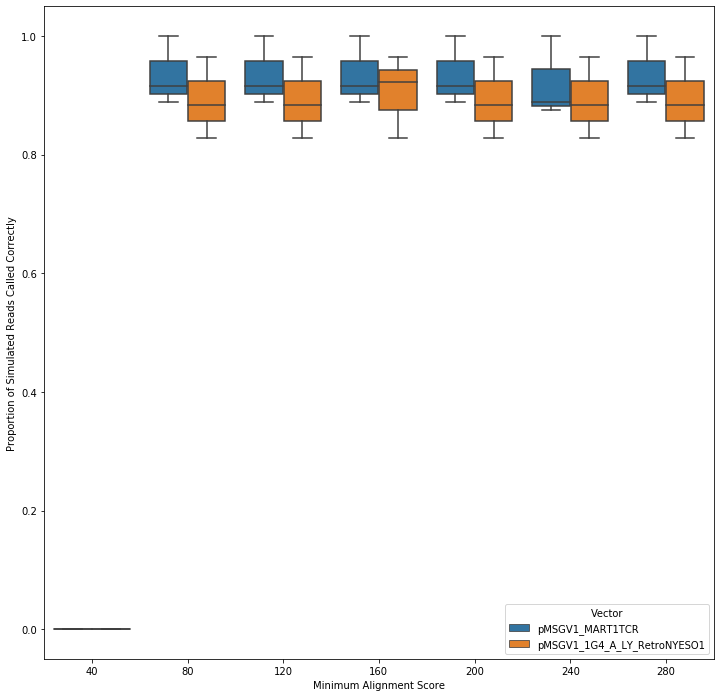

In [77]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x='Minimum Alignment Score', y='Proportion Called', data=int_peak_df, ax=ax, hue='Vector')
ax.set_ylabel('Proportion of Simulated Reads Called Correctly')
plt.show()

In [65]:
int_stats_df = pd.DataFrame(integration_stats).T

In [66]:
int_stats_df.columns = ['On Target Call', 'Off Target Call', 'Vector', 'Minimun Alignment Score']

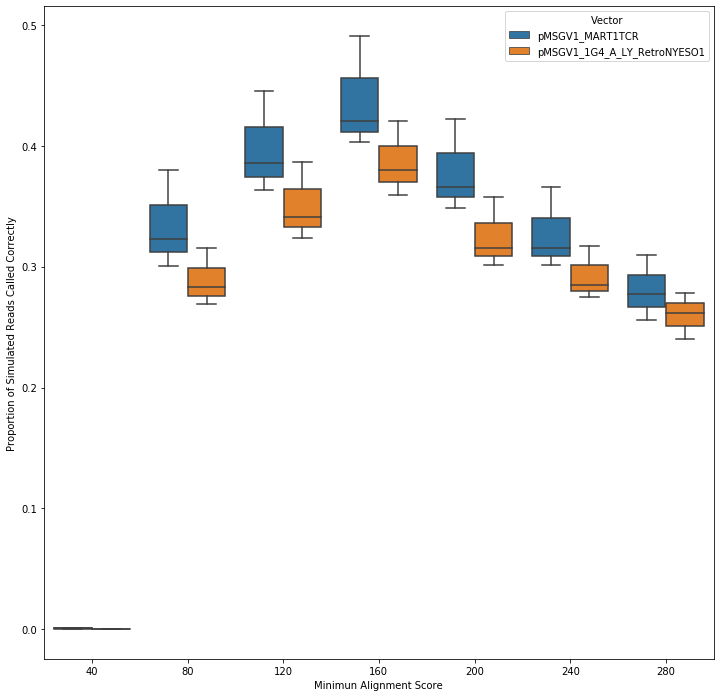

In [67]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x='Minimun Alignment Score', y='On Target Call', data=int_stats_df, ax=ax, hue='Vector')
ax.set_ylabel('Proportion of Simulated Reads Called Correctly')
plt.show()

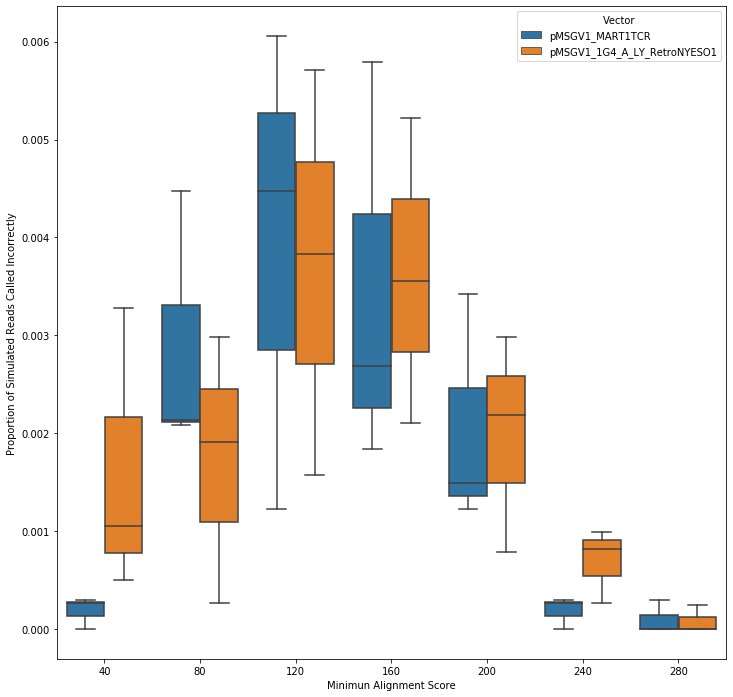

In [68]:
fig, ax = plt.subplots(figsize=(12,12))

sns.boxplot(x='Minimun Alignment Score', y='Off Target Call', data=int_stats_df, ax=ax, hue='Vector')
ax.set_ylabel('Proportion of Simulated Reads Called Incorrectly')

plt.show()